In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/street-view-house-number/train_32x32.mat
/kaggle/input/street-view-house-number/test_32x32.mat


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms
import PIL
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

## Let's make GPU available.

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
USE_GPU = True
DEVICE = torch.device("cpu")

if USE_GPU and torch.cuda.is_available():
    try:
        DEVICE = torch.device("cuda:0")
        print('using device: cuda')
    except:
        print('using device: cpu')
        DEVICE = torch.device('cpu')

using device: cuda


## Load the data. 
PyTorch supports loadind "Street View House Number" database from the box.

In [5]:
data_train = dset.SVHN('/kaggle/input/street-view-house-number/', split='train', download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
data_test = dset.SVHN('/kaggle/input/street-view-house-number/', split='test', download=False, 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

### Lets devide on training and validation data.

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler, pin_memory=True, 
                                           num_workers=6)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler, pin_memory=True, 
                                         num_workers=6)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

## Creating a simple net with ConvLayers.

In [8]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(DEVICE)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

## Trainer utilizing GPU.

In [9]:
from torch.optim.lr_scheduler import MultiStepLR

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, 
                learning_rate_decay = 1, device=DEVICE, milestones = None, gamma = 0.1,
                verbose = False):
    
    model = model.to(device)
    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        if not milestones:
            milestones = [1]
        scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
        
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device, non_blocking=True)
            y_gpu = y.to(device, non_blocking=True)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader, device)
        
        scheduler.step() # updating learning rate
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if verbose:
            print("Epoch: %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch + 1,
                                                                                         ave_loss,
                                                                                         train_accuracy,
                                                                                         val_accuracy))
        if epoch == (num_epochs - 1) and verbose == False:
            print("Epoch: %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch + 1,
                                                                                         ave_loss,
                                                                                         train_accuracy,
                                                                                         val_accuracy))
    return loss_history, train_history, val_history

def compute_accuracy(model, loader, device):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    with torch.no_grad():
        for i_step, (x, y) in enumerate(val_loader):
            x_gpu = x.to(device, non_blocking=True)
            y_gpu = y.to(device, non_blocking=True)
            prediction = model(x_gpu)
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

        val_accuracy = float(correct_samples) / total_samples
        model.train()
        return val_accuracy

In [10]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 5, Average loss: 0.616047, Train accuracy: 0.821486, Val accuracy: 0.811890


## [Data augmentation](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/).

Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model. It is closely related to oversampling in data analysis.

So, to get more data, we just need to make minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images anyway.

![enlargement](https://nanonets.com/blog/content/images/2018/11/1_dJNlEc7yf93K4pjRJL55PA--1-.png)

A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above).

This essentially is the premise of data augmentation. In the real world scenario, we may have a dataset of images taken in a limited set of conditions. But, our target application may exist in a variety of conditions, such as different orientation, location, scale, brightness etc. We account for these situations by training our neural network with additional synthetically modified data.

We'll use technics below:

* ColorJitter - random color change.
* RandomHorizontalFlip - horizontal mirroring with 50% likelyhood.
* RandomVerticalFlip - vertical mirroring with 50% likelyhood.
* RandomRotation - random rotation.

### Visualize some augmentations.

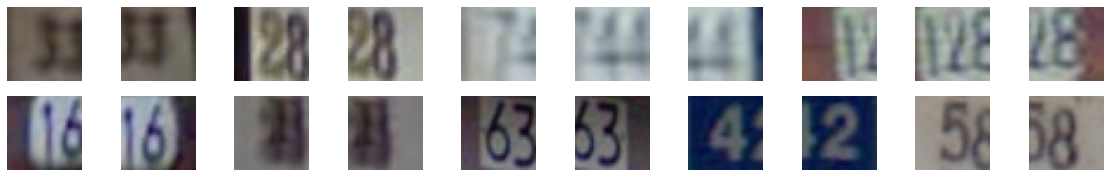

In [11]:
tfs_vis = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_v = dset.SVHN('/kaggle/input/street-view-house-number/',download=False, 
                       transform=tfs_vis
                      )

plt.figure(figsize=(20, 3))

for i, x in enumerate(data_aug_v.data[10:]):
    if i == 20:
        break
    plt.subplot(2, 10, i+1)
    plt.grid(False)
    image = np.moveaxis(x, 0, 2)
    plt.imshow(image)
    plt.axis('off')

We'll left only Color Jitter and RandomRotations. Flips can confuse model, since flipping composed numbers may hide an actual number we are trying to predict.

In [12]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.30, saturation=.30),
    transforms.RandomRotation(35, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('/kaggle/input/street-view-house-number/',download=False, 
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler, pin_memory=True, 
                                               num_workers=6)

### Let's train with augmentations.

In [13]:
loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Epoch: 5, Average loss: 2.478477, Train accuracy: 0.442258, Val accuracy: 0.811617


## LeNet-5.

LeNet is a convolutional neural network structure proposed by Yann LeCun et al. in 1989. In general, LeNet refers to lenet-5 and is a simple convolutional neural network. Convolutional neural networks are a kind of feed-forward neural network whose artificial neurons can respond to a part of the surrounding cells in the coverage range and perform well in large-scale image processing [wiki](https://en.wikipedia.org/wiki/LeNet).

![LeNet-5](https://www.researchgate.net/profile/Muayyad_Alsadi/publication/329970273/figure/fig4/AS:708840312020993@1546012108524/LeNet-5-CNN-desgin-Source-LeCun-Bottou-Bengio-Haffner-1998.png)

>Convolutional Neural Networks are are a special kind of multi-layer neural networks. Like almost every other neural networks they are trained with a version of the back-propagation algorithm. Where they differ is in the architecture.  
Convolutional Neural Networks are designed to recognize visual patterns directly from pixel images with minimal preprocessing. 
They can recognize patterns with extreme variability (such as handwritten characters), and with robustness to distortions and simple geometric transformations.  
LeNet-5 is our latest convolutional network designed for handwritten and machine-printed character recognition. 
Here is an example of LeNet-5 in action.[yann lecun page](http://yann.lecun.com/exdb/lenet/) 

![LeNet_5_in_action](https://lh3.googleusercontent.com/proxy/aTQf5JQsbY0oQ6zZ8JqKYxtefceKBHfusJ5jNGjgkoK9yIYNT-TaT0huWjje1AWHUIlh7k7BxSOGsTqYXTyUd3Z7nTVpsseL70E)

Architecture form description in the [original article](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf):

* Layer C1 is convolutional layer with filter size 5 x 5, stride = 1, padding = 0, input_dim = 3, output_dim = 6.
* Hyperbolic Tangent function with parameter A = 1.7159.
* Layer S2 is sub-sampling layer (AveragePooling) with filter size = 2, strides = 2, padding = 0.
* Hyperbolic Tangent function with parameter A = 1.7159.
* Layer C3 is convolutional layer with filter size 5 x 5 (depends on S2 filter size, shown in Table 1.), stride = 1, padding = 0, input_dim = 6, output_dim = 16.
* Hyperbolic Tangent function with parameter A = 1.7159.
* Layer S4 is sub-sampling layer (AveragePooling) with filter size = 2, strides = 2, padding = 0
* Flatten the output of previous layer.
* Layer C5 is fully-connected layer with input_dim = 400, output_dim = 120.
* Hyperbolic Tangent function with parameter A = 1.7159.
* Layer F6 is fully-connected layer with input_dim = 120, output_dim = 84
* Hyperbolic Tangent function with parameter A = 1.7159.
* Fully-connected layer with input_dim = 84, output_dim = 10.
* Softmax.
* Loss function is Mean Squared Error

In [14]:
class MultiplyByConstant(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(1.7159))

    def forward(self, x):
        return x * self.alpha

In [15]:
lenet_5_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, 
                      kernel_size=(5,5), stride=1, padding=0),
            nn.Tanh(),
            MultiplyByConstant(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, 
                      kernel_size=(5,5), stride=1, padding=0),
            nn.Tanh(),
            MultiplyByConstant(),
            nn.AvgPool2d(kernel_size=2, stride=2),    
            Flattener(),
            nn.Linear(400, 120),
            nn.Tanh(),
            MultiplyByConstant(),
            nn.Linear(120, 84),
            nn.Tanh(),
            MultiplyByConstant(),
            nn.Linear(84, 10),
          )

lenet_5_model.type(torch.cuda.FloatTensor)
lenet_5_model.to(DEVICE)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_5_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [16]:
loss_history, train_history, val_history = train_model(lenet_5_model, 
                                                       train_aug_loader, 
                                                       val_loader, 
                                                       loss, optimizer, 
                                                       10,
                                                       verbose=True)
for layer in lenet_5_model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Epoch: 1, Average loss: 1.713248, Train accuracy: 0.412739, Val accuracy: 0.742475
Epoch: 2, Average loss: 0.778656, Train accuracy: 0.755554, Val accuracy: 0.798307
Epoch: 3, Average loss: 0.714497, Train accuracy: 0.775740, Val accuracy: 0.805542
Epoch: 4, Average loss: 0.711748, Train accuracy: 0.778930, Val accuracy: 0.806566
Epoch: 5, Average loss: 0.707185, Train accuracy: 0.778470, Val accuracy: 0.807044
Epoch: 6, Average loss: 0.708760, Train accuracy: 0.779715, Val accuracy: 0.806907
Epoch: 7, Average loss: 0.709250, Train accuracy: 0.779408, Val accuracy: 0.806907
Epoch: 8, Average loss: 0.704428, Train accuracy: 0.781319, Val accuracy: 0.806907
Epoch: 9, Average loss: 0.710520, Train accuracy: 0.778777, Val accuracy: 0.806907
Epoch: 10, Average loss: 0.706212, Train accuracy: 0.779425, Val accuracy: 0.806907


## Hyperparameter optimization.

In [17]:
from collections import namedtuple

Hyperparams = namedtuple("Hyperparams", 
                         ['learning_rate',
                          'gamma',
                          'milestones', 
                          'reg'])
RunResult = namedtuple("RunResult", 
                       ['model',
                        'train_history', 
                        'val_history',
                        'final_val_accuracy'])

batch_size = 64
epoch_num = 10

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

gamma = 0.2
milestones = [
              [range(epoch_num)],
              [2,4,6,8,10],
              [1, 3, 7, 10]
             ]

reg = [1e-3, 1e-4, 1e-5, 1e-7]
                       
run_record = {}

In [18]:
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, 
                      kernel_size=(5,5), stride=1, padding=0),
            nn.Tanh(),
            MultiplyByConstant(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, 
                      kernel_size=(5,5), stride=1, padding=0),
            nn.Tanh(),
            MultiplyByConstant(),
            nn.AvgPool2d(kernel_size=2, stride=2),    
            Flattener(),
            nn.Linear(400, 120),
            nn.Tanh(),
            MultiplyByConstant(),
            nn.Linear(120, 84),
            nn.Tanh(),
            MultiplyByConstant(),
            nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(DEVICE)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): MultiplyByConstant()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Tanh()
  (6): MultiplyByConstant()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Flattener()
  (9): Linear(in_features=400, out_features=120, bias=True)
  (10): Tanh()
  (11): MultiplyByConstant()
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): Tanh()
  (14): MultiplyByConstant()
  (15): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
loss_histories = list()
train_histories = list()
val_histories = list()

for lr in learning_rates:
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=1e-3)

    loss_history, train_history, val_history = train_model(lenet_model, 
                                                           train_aug_loader, 
                                                           val_loader, 
                                                           loss, optimizer, 
                                                           10,
                                                           verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    
    run_record[Hyperparams(lr, str([1]), gamma, 1e-3)] = RunResult(lenet_model, 
                                                              train_history, 
                                                              val_history,
                                                              val_history[-1])
    
    for layer in lenet_model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Epoch: 10, Average loss: 0.691785, Train accuracy: 0.785636, Val accuracy: 0.809296
Epoch: 10, Average loss: 2.128063, Train accuracy: 0.273931, Val accuracy: 0.287625
Epoch: 10, Average loss: 2.234911, Train accuracy: 0.190885, Val accuracy: 0.195755
Epoch: 10, Average loss: 2.281709, Train accuracy: 0.155667, Val accuracy: 0.135213


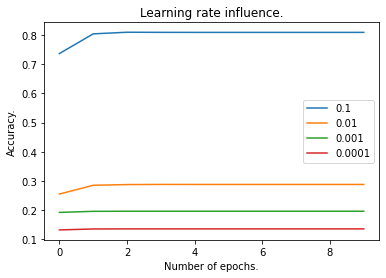

In [20]:
count = 0
for val in val_histories:
    plt.plot(val, label = learning_rates[count])
    plt.title('Learning rate influence.')
    plt.xlabel("Number of epochs.")
    plt.ylabel("Accuracy.")
    plt.legend()
    count += 1

In [21]:
loss_histories = list()
train_histories = list()
val_histories = list()

for ms in milestones:
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-3)

    loss_history, train_history, val_history = train_model(lenet_model, 
                                                           train_aug_loader, 
                                                           val_loader, 
                                                           loss, optimizer, 
                                                           10,
                                                           milestones=ms,
                                                           gamma=gamma,
                                                           verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    
    run_record[Hyperparams(1e-1, str(ms), gamma, 1e-3)] = RunResult(lenet_model, 
                                                               train_history, 
                                                               val_history,
                                                               val_history[-1])
    
    for layer in lenet_model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Epoch: 10, Average loss: 0.552208, Train accuracy: 0.830290, Val accuracy: 0.813460
Epoch: 10, Average loss: 0.517107, Train accuracy: 0.840085, Val accuracy: 0.839397
Epoch: 10, Average loss: 0.672785, Train accuracy: 0.790892, Val accuracy: 0.814688


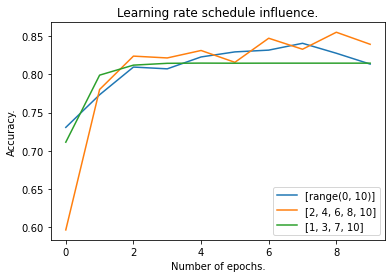

In [22]:
count = 0
for val in val_histories:
    plt.plot(val, label = milestones[count])
    plt.title('Learning rate schedule influence.')
    plt.xlabel("Number of epochs.")
    plt.ylabel("Accuracy.")
    plt.legend()
    count += 1

In [23]:
loss_histories = list()
train_histories = list()
val_histories = list()

for r in reg:
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=r)

    loss_history, train_history, val_history = train_model(lenet_model, 
                                                           train_aug_loader, 
                                                           val_loader, 
                                                           loss, optimizer, 
                                                           10,
                                                           milestones=milestones[1],
                                                           gamma=gamma,
                                                           verbose=False)
    loss_histories.append(loss_history)
    train_histories.append(train_history)
    val_histories.append(val_history)
    
    run_record[Hyperparams(1e-1, str(milestones[1]), gamma, r)] =  RunResult(lenet_model, 
                                                                        train_history, 
                                                                        val_history,
                                                                        val_history[-1])
    
    for layer in lenet_model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Epoch: 10, Average loss: 0.547326, Train accuracy: 0.831400, Val accuracy: 0.829773
Epoch: 10, Average loss: 0.476356, Train accuracy: 0.851978, Val accuracy: 0.857552
Epoch: 10, Average loss: 0.468812, Train accuracy: 0.853735, Val accuracy: 0.855232
Epoch: 10, Average loss: 0.454710, Train accuracy: 0.859417, Val accuracy: 0.862945


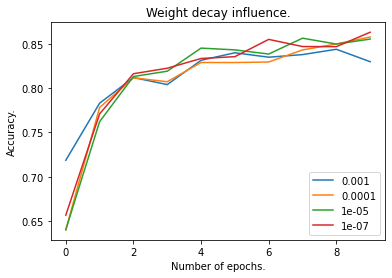

In [24]:
count = 0
for val in val_histories:
    plt.plot(val, label = reg[count])
    plt.title('Weight decay influence.')
    plt.xlabel("Number of epochs.")
    plt.ylabel("Accuracy.")
    plt.legend()
    count += 1

## The best model based on LeNet-5 architucture.

In [25]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.86, best hyperparams: Hyperparams(learning_rate=0.1, gamma='[2, 4, 6, 8, 10]', milestones=0.2, reg=1e-07)


## Let's achieve higher accuracy with custom model.

### Firstly, we'll try building model based on [CS231 guidence](https://cs231n.github.io/convolutional-networks/).

The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point, it is common to transition to fully-connected layers. The last fully-connected layer holds the output, such as the class scores. In other words, the most common ConvNet architecture follows the pattern:

INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC

where the * indicates repetition, and the POOL? indicates an optional pooling layer. Moreover, N >= 0 (and usually N <= 3), M >= 0, K >= 0 (and usually K < 3). For example, here are some common ConvNet architectures you may see that follow this pattern:

INPUT -> FC, implements a linear classifier. Here N = M = K = 0.
INPUT -> CONV -> RELU -> FC
INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC. Here we see that there is a single CONV layer between every POOL layer.
INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC Here we see two CONV layers stacked before every POOL layer. This is generally a good idea for larger and deeper networks, because multiple stacked CONV layers can develop more complex features of the input volume before the destructive pooling operation.

In [26]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, 
                      kernel_size=(2,2), stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=(2,2), stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=(2,2), stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=(3,3), stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=(2,2), stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=(3,3), stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Flattener(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10),
          )

model.type(torch.cuda.FloatTensor)
model.to(DEVICE)

Sequential(
  (0): Conv2d(3, 128, kernel_size=(2, 2), stride=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
  (15): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_r

In [27]:
for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=128, 
                                           sampler=train_sampler, pin_memory=True, 
                                               num_workers=6)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_history, train_history, val_history = train_model(model, 
                                                        train_aug_loader, 
                                                        val_loader, 
                                                        loss, optimizer,
                                                        25,
                                                        milestones=[5, 15, 25],
                                                        gamma=0.2,
                                                        verbose=True)

Epoch: 1, Average loss: 0.873401, Train accuracy: 0.712487, Val accuracy: 0.870862
Epoch: 2, Average loss: 0.413287, Train accuracy: 0.871924, Val accuracy: 0.886629
Epoch: 3, Average loss: 0.349150, Train accuracy: 0.891632, Val accuracy: 0.908402
Epoch: 4, Average loss: 0.309397, Train accuracy: 0.906375, Val accuracy: 0.913931
Epoch: 5, Average loss: 0.282983, Train accuracy: 0.913183, Val accuracy: 0.918709
Epoch: 6, Average loss: 0.255311, Train accuracy: 0.923080, Val accuracy: 0.918094
Epoch: 7, Average loss: 0.243511, Train accuracy: 0.926117, Val accuracy: 0.920415
Epoch: 8, Average loss: 0.228806, Train accuracy: 0.931867, Val accuracy: 0.925125
Epoch: 9, Average loss: 0.214439, Train accuracy: 0.935877, Val accuracy: 0.921029
Epoch: 10, Average loss: 0.203127, Train accuracy: 0.939887, Val accuracy: 0.928469
Epoch: 11, Average loss: 0.189551, Train accuracy: 0.943265, Val accuracy: 0.928469
Epoch: 12, Average loss: 0.179363, Train accuracy: 0.946217, Val accuracy: 0.930653
E

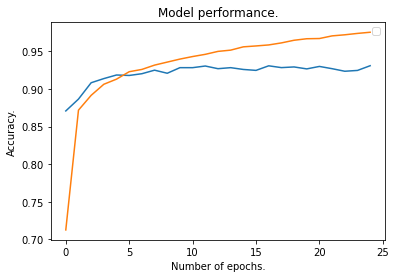

In [28]:
plt.plot(val_history)
plt.plot(train_history)
plt.title('Model performance.')
plt.xlabel("Number of epochs.")
plt.ylabel("Accuracy.")
plt.legend()

In [29]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)
test_accuracy = compute_accuracy(model, test_loader, DEVICE)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.9311


## Let's visualize the most often mistakes the model makes on test data

In [30]:
class SubsetSampler(Sampler):
    """Samples elements with given indices sequentially.

    Args:
        indices (ndarray): indices of the samples to take.
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset.
    
    Returns:
    
    predictions (numpy array of ints): model predictions.
    grount_truth (numpy array of ints): actual labels of the dataset.
    """
    model.eval()
    predictions = np.zeros_like(indices)
    ground_truth = np.zeros_like(indices)
    count = 0
    with torch.no_grad():
        for i in SubsetSampler(indices):
            sample, label = dataset[i]
            prediction = model(torch.reshape(sample, (1,3,32,32)).type(torch.cuda.FloatTensor))
            _, index = torch.max(prediction, 1)
            predictions[count]  = index
            ground_truth[count] = label 
            count += 1
    model.train()
    
    return predictions, ground_truth

def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix.
    
    confusion_matrix (numpy array of ints, x axis - predicted class, y axis - actual class):
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth.
    
    Args:
    predictions (numpy array of ints): model predictions for all validation samples.
    ground_truth (numpy array of ints): ground truth for all validation samples.
    
    Returns:
    (numpy array of ints, (10,10)): counts of samples for predicted/ground_truth classes.
    """
    confusion_matrix = np.zeros((10,10), np.int)
    index = tuple(np.array(list(zip(predictions,ground_truth))).T)
    np.add.at(confusion_matrix, index, 1)
    return confusion_matrix

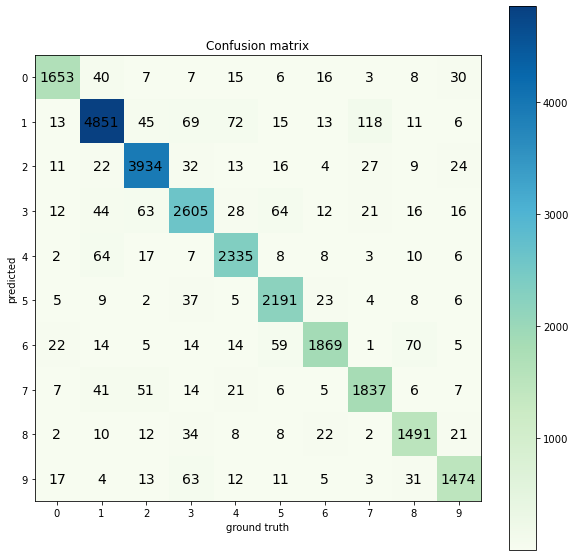

In [31]:
test_data_size = data_test.data.shape[0]
test_indices = list(range(test_data_size))

predictions, gt = evaluate_model(model, data_test, test_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

In [32]:
def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset.
     
    Args:
    indices (numpy array of int): array of indices to visualize.
    data (PyTorch Dataset object): dataset with the images.
    title (string): title of the plot.
    max_num (int): max number of images to display.
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = np.moveaxis(data[index], 0, 2)
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class.
    
    Args:
    predicted (int 0-9): index of the predicted class.
    gt_class (int 0-9): index of the ground truth class.
    predictions (numpy array of ints): model predictions for all validation samples.
    ground_truth (numpy array of ints): ground truth for all validation samples.
    val_indices (numpy array of ints): indices of validation samples.
    """
    validation_set = data.data[val_indices]
#     validation_labels = data.labels[val_indices
#     assert np.array_equal(validation_labels, groud_truth)
    
    indices = np.where(np.logical_and(predictions == predicted_class, # finding intersection of two
                                      groud_truth == gt_class) == True)[0] # boolean arrays
    
    visualize_images(indices, validation_set, 
                     f'Visualization of images where model mistakes {gt_class} for {predicted_class}.')

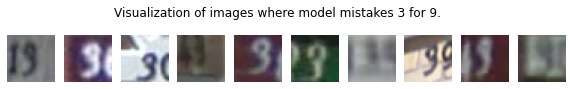

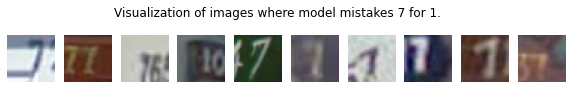

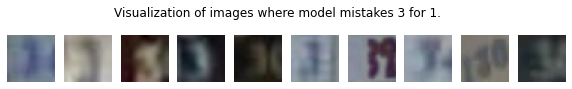

In [33]:
data_test_images = dset.SVHN('/kaggle/input/street-view-house-number/',
                             split='test', download=False)
visualize_predicted_actual(9, 3, predictions, gt, np.array(test_indices), data_test_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(test_indices), data_test_images)
visualize_predicted_actual(1, 3, predictions, gt, np.array(test_indices), data_test_images)